In [28]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

In [2]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            variables[key.strip()] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [3]:
experiment_sub_dir = "2025Mar13-144809_configs"
exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'estimator.args_.lin_hidden_out_size', 'seed', 'experiment_name'],
      dtype='object')

In [4]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_max,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,estimator.args_.lin_hidden_out_size,seed,experiment_name
0,training,200000,-96.175579,-38.428016,-69.763325,-71.768760,9.518847,-71.570636,-33.195098,-54.486824,...,0.063867,-0.928016,-0.588658,0.933250,48749.0,48.0,0 days 00:02:34.901718,32,0,0000_estimator.args_.lin_hidden_out_size_32
1,training,400000,-97.209271,-64.910624,-74.745826,-74.290366,4.047642,-70.863635,-50.483917,-56.998082,...,-0.055973,-2.171356,-1.607381,1.755914,50000.0,48.0,0 days 00:02:39.411581,32,0,0000_estimator.args_.lin_hidden_out_size_32
2,training,600000,-90.002593,-57.455420,-69.741451,-69.568764,3.906731,-67.624469,-46.827370,-54.506387,...,0.009901,-3.129743,-2.569881,2.403537,50000.0,52.0,0 days 00:02:39.855486,32,0,0000_estimator.args_.lin_hidden_out_size_32
3,training,800000,-80.847129,-51.915249,-61.754139,-61.471434,4.035495,-63.933977,-43.748122,-50.303482,...,0.091709,-3.858633,-3.661908,3.041318,50000.0,48.0,0 days 00:02:37.877943,32,0,0000_estimator.args_.lin_hidden_out_size_32
4,training,1000000,-90.406993,-46.890870,-60.054628,-58.179667,7.016581,-64.420199,-40.220326,-48.194207,...,0.132569,-2.752129,-0.602380,3.452035,50000.0,52.0,0 days 00:02:40.501765,32,0,0000_estimator.args_.lin_hidden_out_size_32
5,training,1200000,-108.532206,-27.074319,-52.943470,-47.497785,17.136863,-69.799790,-24.563775,-41.359060,...,-0.113428,-1.707795,-0.746534,2.610633,50000.0,48.0,0 days 00:02:39.003995,32,0,0000_estimator.args_.lin_hidden_out_size_32
6,training,1400000,-110.820101,-24.731278,-33.522920,-32.090018,6.027516,-67.390256,-22.633143,-29.377329,...,-0.097510,-1.332330,-0.776741,1.299847,50000.0,52.0,0 days 00:02:40.638505,32,0,0000_estimator.args_.lin_hidden_out_size_32
7,training,1600000,-63.338452,-24.431993,-31.339063,-30.743442,3.747083,-47.000408,-22.394784,-27.519645,...,-0.263443,-1.246569,-0.604138,1.247136,50000.0,48.0,0 days 00:02:43.585205,32,0,0000_estimator.args_.lin_hidden_out_size_32
8,training,1800000,-101.100429,-24.065655,-32.899976,-31.486521,6.613334,-71.507249,-22.111397,-28.593099,...,-0.298288,-1.321922,-0.705408,1.242203,50000.0,52.0,0 days 00:02:58.875752,32,0,0000_estimator.args_.lin_hidden_out_size_32
9,training,2000000,-43.935482,-23.427701,-29.717361,-29.274756,3.081004,-34.779457,-21.680715,-26.178615,...,-0.387239,-1.359132,-0.732194,1.238958,50000.0,48.0,0 days 00:03:36.814173,32,0,0000_estimator.args_.lin_hidden_out_size_32


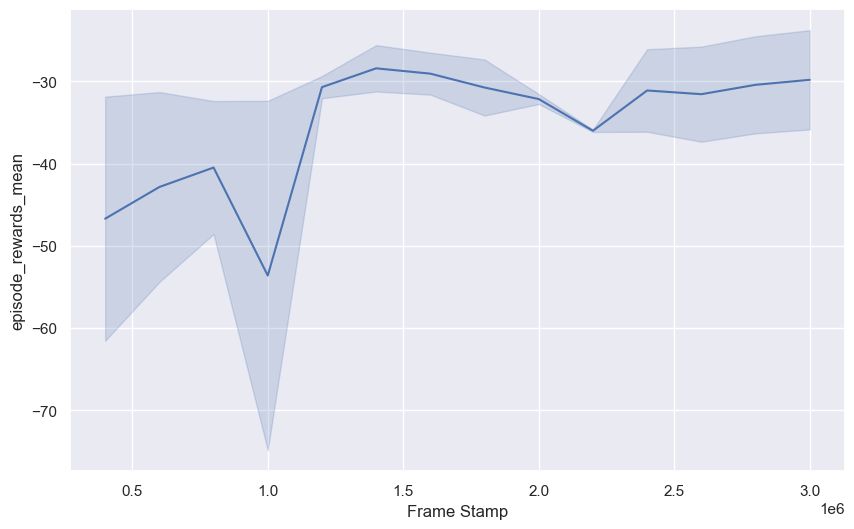

In [29]:
selected_metric = 'episode_rewards_mean'
# Filter for validation episodes
validation_df = df[df['epoch_type'] == 'validation']

# Get the unique sorted frame_stamp values
unique_frames = np.sort(validation_df['frame_stamp'].unique())
N = 1
# Get all frame_stamp values after the first N unique ones
filtered_frames = unique_frames[N:]

# Filter the DataFrame to only include rows with these frame_stamp values
filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

plt.figure(figsize=(10, 6))
sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric)
plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.show()

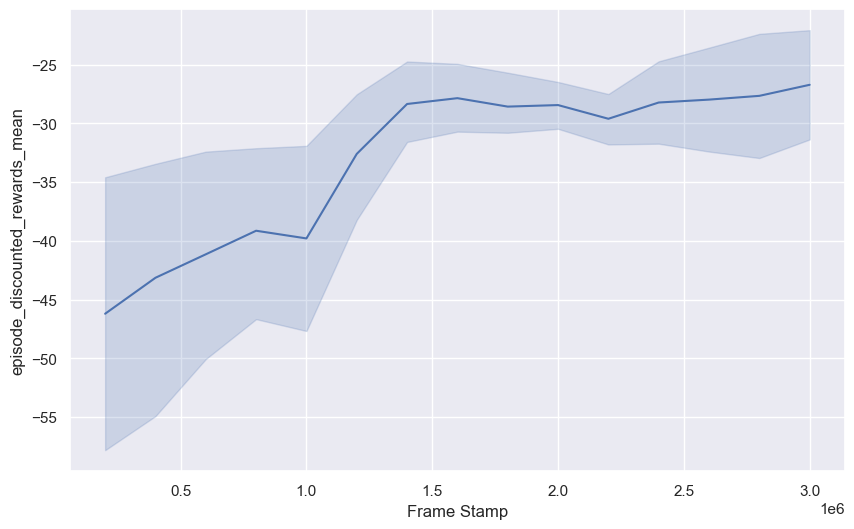

In [22]:

selected_metric = 'episode_discounted_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()